# Consumer Reviews Summarization - Project Part 3


[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Ariamestra/ConsumerReviews/blob/main/project_part3.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ariamestra/ConsumerReviews/blob/main/project_part3.ipynb)


## 1. Introduction
My goal for this project is to develop a system capable of generating concise summaries of customer reviews. This will help users in quickly skim through feedback on products by transforming detailed reviews into short comments. These comments will be categorized as positive, neutral, or negative, corresponding to the sentiment of the rating provided. To achieve this, the system will use the capabilities of the pre-trained T5 model. I selected the T5 model as my pre-trained choice because it is a text-to-text transformer, thats good at tasks like summarization. I opted for [T5-small](https://huggingface.co/t5-small) due to its size, which is more manageable. Additionally, T5 is versatile in handling different summarization types, like extractive summarization where it picks out important sentences from the text.<br>
<br>

**Data** <br>
The dataset was sourced from Kaggle, specifically the [Consumer Review of Clothing Product](https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product)
 dataset. This dataset includes customer reviews from Amazon. It has all sorts of feedback from buyers about different products. Along with the customers' actual reviews, ratings, product type, material, construction, color, finish, and durability.<br>



In [36]:
# Import all packages needed
#!pip install transformers pandas nltk scikit-learn
#!pip install sentencepiece
#!pip install transformers[torch]


import pandas as pd
import re
import nltk
import torch
import sys
import sentencepiece as spm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')       
nltk.download('stopwords')  
nltk.download('wordnet')     

MODEL_NAME = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
print(f"Shape: {df.shape}")
df.head()

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Shape: (49338, 9)


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


The Kernel crashed while executing code in the the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure.

Model training

In [37]:
# Count the number of nulls in reviews
number_of_nulls = df['Review'].isnull().sum()
print(f"Number of nulls in the reviews: {number_of_nulls}")

# Calculate the number of nulls in rating
number_of_nulls_in_ratings = df['Cons_rating'].isnull().sum()
print(f"Number of nulls in the ratings: {number_of_nulls_in_ratings}")

original_count = df.shape[0]
df_cleaned = df.dropna(subset=['Review', 'Cons_rating']) # Drop rows with nulls in reviews and ratings columns
cleaned_count = df_cleaned.shape[0] # Number of rows after dropping nulls
rows_dropped = original_count - cleaned_count

print(f"Number of rows dropped: {rows_dropped}")

# Get the shape after dropping null values
df_shape_after_dropping = df_cleaned.shape

print(f"Shape of the DataFrame after dropping rows: {df_shape_after_dropping}")

Number of nulls in the reviews: 831
Number of nulls in the ratings: 214
Number of rows dropped: 1043
Shape of the DataFrame after dropping rows: (48295, 9)


In [38]:
# Review length of reviews
df_cleaned = df_cleaned.copy()
df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))

# Filter out reviews that are shorter than 20 words 
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 30].index, inplace=True)

# Longest and shortest reviews in df_cleaned
longest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmax()]
longest_review = longest_review_row['Review']
longest_review_length = longest_review_row['Review_length']

shortest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmin()]
shortest_review = shortest_review_row['Review']
shortest_review_length = shortest_review_row['Review_length']

print(f"Longest review length: {longest_review_length} words")
print(f"Shortest review length: {shortest_review_length} words")
print(f"Shape of the DataFrame after dropping rows below 20 words: {df_cleaned.shape}")

Longest review length: 668 words
Shortest review length: 30 words
Shape of the DataFrame after dropping rows below 20 words: (26680, 10)


In [39]:
# Clean reviews
stop_words = set(stopwords.words('english'))

def clean_review(review):
    review = str(review).lower()
    review = review.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stop words
    words = word_tokenize(review)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    # Join string
    review = ' '.join(words)
    return review

print(f"Done")

Done


In [40]:
# Converts it to a numerical format using TF-IDF vectorization and then splits the dataset into training and test sets.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import string

df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Processed_Review'], df_cleaned['Cons_rating'], test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)

# Fit to the training data 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X = df_cleaned['Processed_Review']
y = df_cleaned['Cons_rating']

# Now you can proceed with your existing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Calculate the total number 
total_samples = X.shape[0]
train_size = X_train.shape[0]
test_size = X_test.shape[0]


train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

print(f"Total dataset size: {total_samples}")
print(f"Train size: {train_size} ({train_percentage:.2f}%)")
print(f"Test size: {test_size} ({test_percentage:.2f}%)")

Total dataset size: 26680
Train size: 21344 (80.00%)
Test size: 5336 (20.00%)


Model Training

Best Accuracy: 0.558095952023988, Best C for Accuracy: 1.623776739188721
Best Log Loss: 1.104818548274103, Best C for Log Loss: 10000.0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


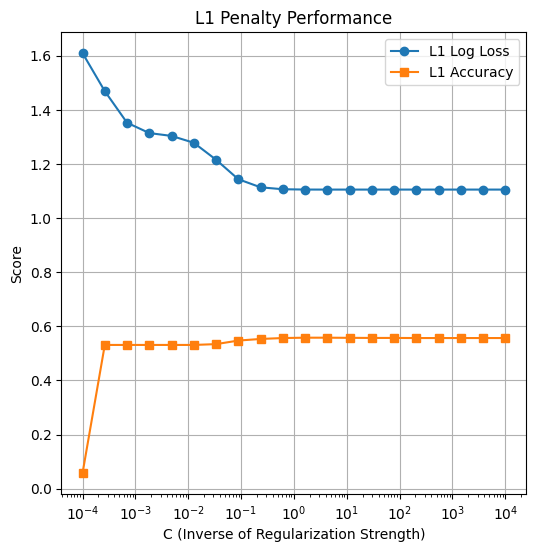

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Predict probabilities on the test set
y_pred_proba = lr_model.predict_proba(X_test_tfidf)

# Calculate the log loss (cross-entropy loss)
loss = log_loss(y_test_encoded, y_pred_proba)

# Define the model and parameters
lr = LogisticRegression(random_state=42)
param_grid = {
    'C': np.logspace(-4, 4, 20),  # 20 values between 10^-4 and 10^4
    'penalty': ['l1', 'l2'],  # l1 and l2 regularization
    'solver': ['liblinear']  # 'liblinear' works well with l1 and l2
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(X_train_tfidf, y_train_encoded)

# Get the best parameters and the corresponding log loss
best_params = grid_search.best_params_
best_log_loss = -grid_search.best_score_

# Your existing code for GridSearchCV
# ...

# Fit and evaluate GridSearchCV
grid_search.fit(X_train_tfidf, y_train_encoded)

# Get CV results
cv_results = grid_search.cv_results_

# Create a DataFrame from the CV results
results_df = pd.DataFrame(cv_results)

# Add a new column for test set accuracy for each hyperparameter combination
test_accuracies = []
log_losses = []
for i in range(results_df.shape[0]):
    # Retrieve the model
    model = grid_search.best_estimator_.set_params(**results_df.loc[i, 'params'])

    # Fit and predict
    model.fit(X_train_tfidf, y_train_encoded)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)

    # Calculate and store accuracy and log loss
    test_accuracies.append(accuracy_score(y_test_encoded, y_pred))
    log_losses.append(log_loss(y_test_encoded, y_pred_proba))

results_df['test_accuracy'] = test_accuracies
results_df['test_log_loss'] = log_losses

# Find the best accuracy and corresponding log loss
'''
best_accuracy_index = np.argmax(results_df['test_accuracy'])
best_accuracy = results_df['test_accuracy'][best_accuracy_index]
best_loss = results_df['test_log_loss'][best_accuracy_index]
best_C = results_df['param_C'][best_accuracy_index]

print(f"Best Accuracy: {best_accuracy}")
print(f"Corresponding Log Loss: {best_loss}")
print(f"Best C Value: {best_C}")
'''
best_accuracy_index = np.argmax(results_df['test_accuracy'])
best_accuracy = results_df['test_accuracy'][best_accuracy_index]
best_C_for_accuracy = results_df['param_C'][best_accuracy_index]

# Find the index and value of the best log loss and corresponding C value
best_log_loss_index = np.argmin(results_df['test_log_loss'])
best_log_loss = results_df['test_log_loss'][best_log_loss_index]
best_C_for_log_loss = results_df['param_C'][best_log_loss_index]

print(f"Best Accuracy: {best_accuracy}, Best C for Accuracy: {best_C_for_accuracy}")
print(f"Best Log Loss: {best_log_loss}, Best C for Log Loss: {best_C_for_log_loss}")
print('-' * 200)

# Separate data for l1 penalty (assuming you are only using L1)
l1_data = results_df[results_df['param_penalty'] == 'l1']

# Plotting
plt.figure(figsize=(6, 6))

# Plot for L1 penalty
plt.plot(l1_data['param_C'], -l1_data['mean_test_score'], label='L1 Log Loss', marker='o')
plt.plot(l1_data['param_C'], l1_data['test_accuracy'], label='L1 Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Score')
plt.title('L1 Penalty Performance')
plt.legend()
plt.grid(True)

plt.show()


Model Evaluation

In [42]:
#---------------------------- Work --------------------------------------------------------
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameters for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Algorithm to use for optimization
}

# Initialize the GridSearchCV with the Logistic Regression model and parameter grid
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train_encoded)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Predict on the test set using the best found parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the best model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy of the best model: {accuracy}")
print('-' * 100)

# Detailed classification report
print(classification_report(y_test_encoded, y_pred))


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters: {'C': 1, 'solver': 'sag'}
Accuracy of the best model: 0.5564092953523239
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.36      0.21      0.27       308
           1       0.27      0.05      0.09       429
           2       0.30      0.22      0.25       700
           3       0.38      0.16      0.23      1064
           4       0.62      0.90      0.74      2835

    accuracy                           0.56      5336
   macro avg       0.39      0.31      0.31      5336
weighted avg       0.49      0.56      0.49      5336



Model Tuning

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

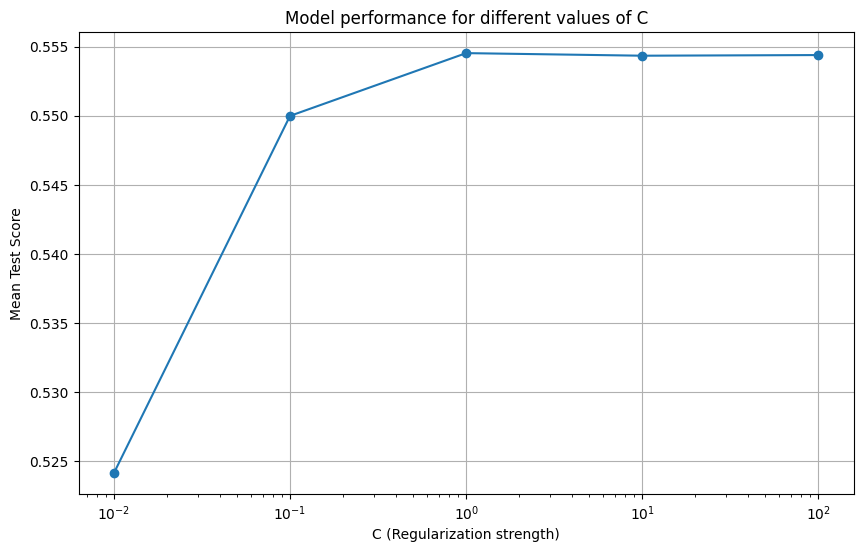

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameters for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Initialize the GridSearchCV with the Logistic Regression model and parameter grid
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train_encoded)

# Extracting results
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))

# Plotting the mean test scores for each hyperparameter value
plt.plot(results['param_C'], results['mean_test_score'], marker='o')

plt.title('Model performance for different values of C')
plt.xlabel('C (Regularization strength)')
plt.ylabel('Mean Test Score')
plt.xscale('log')  # Use logarithmic scale for better visualization
plt.grid(True)

plt.show()


Summerization

In [44]:
# Sentiment analysis
def classify_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df_cleaned['Sentiment'] = df_cleaned['Cons_rating'].apply(classify_sentiment)


In [45]:
# Test Summerization

def summarize_review(review):
    # Prepend "summarize: " to the review text
    input_text = "summarize: " + review
    # Encode and generate summary
    inputs = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Apply summarization to a subset of reviews for demonstration
# df_cleaned['Summary'] = df_cleaned['Review'].head(10).apply(summarize_review)


In [46]:
def word_count(text):
    return len(text.split())

for index, row in df_cleaned.head(15).iterrows():
    sentiment = classify_sentiment(row['Cons_rating'])
    summary = summarize_review(row['Review'])
    original_word_count = word_count(row['Review'])
    summary_word_count = word_count(summary)

    print(f"Original Review: {row['Review']}\n"
          f"Original Review Word Count: {original_word_count}\n"
          f"Sentiment: {sentiment}\n\n"
          f"Summary: {summary}\n"
          f"Summary Word Count: {summary_word_count}\n"
          f"{'-' * 100}\n") 
        
    

AttributeError: 'LogisticRegression' object has no attribute 'generate'

## Conclusion
In conclusion, the project has successfully used the pre-trained T5 model to transform extensive customer reviews into brief summaries. This advancement not only enhances the efficiency of user evaluations by providing understanding into product feedback. The implementation of this summarization tool shows practical use of text-to-text transformers in real-world scenarios, simplifying the decision-making process for consumers.